In [2]:
from varyingsim.osi import OSI
from varyingsim.push_box import PushBox
from varyingsim.util.buffers import TrajBuffer
from varyingsim.algos.BufferedOSI import BufferedCartpoleOSI

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

%matplotlib widget
import matplotlib.pyplot as plt

import aim
from copy import deepcopy
import pickle

In [3]:
included_fovs = np.array([0])
included_fovs_idxs = included_fovs + 9
n_fov = len(included_fovs)
shapes = [(9,), (8,), (9,), (8,), (2,), (n_fov,)] # qpos, qvel, prevqpos, prevqvel, action, fovs
device = 'cuda'
SCALE = 1000
LOAD_LEARNERS = False

In [12]:
class Split():
    DELTA='delta'
    QUAT = 'quat'
    NONE = 'none'
    
    TYPES = [DELTA, QUAT, NONE]
    
    def __init__(self, length, split_type):
        self.length = length
        if split_type not in self.TYPES:
            raise Exception('split_type must be one of', self.TYPES)
        self.split_type = split_type
    
    def __repr__(self):
        return self.split_type + '({})'.format(self.length)

qpos_split = [Split(3, Split.DELTA), Split(3, Split.DELTA), Split(3, Split.DELTA)]

In [3]:
def obs_to_datum(obs, prev_obs, a):
    """
    obs is qpos, qvel, prevqpos, prevqvel, action, cart mass, pole mass, end mass, rotation
    """
    xy = obs[0:2]
    xy_vel = obs[2:4]
    xy_prev = prev_obs[0:2]
    xy_vel_prev = prev_obs[2:4]
#     fovs = prev_obs[included_fovs_idxs] # TODO: should this be previous?
    fovs = obs[included_fovs_idxs] # TODO: should this be previous?
    act = np.array(a)

    return xy, xy_vel, xy_prev, xy_vel_prev, act, fovs 

def get_data(env, buffer, T, seed=0xDEADBEEF, p_action_change=P_ACTION_CHANGE):
    np.random.seed(seed)
    obs = env.reset()
    t = 0
    
    buffer.set_new_traj()
    a = [np.random.rand() * 2 - 1]
    while t < T:
        if np.random.rand() < p_action_change:
            a = [np.random.rand() * 2 - 1]
            
        prev_obs = obs
        obs, rew, done, info = env.step(a)
        datum = obs_to_datum(obs, prev_obs, a)
        buffer.add_datum(datum)
        t += 1
        
    return buffer

def buffer_to_osi_torch(batch):
    """
        takes in a batch from a TrajBuffer and returns a pytorch batch
        of size N x h x d_in
    """
    N, h, _ = batch[0].shape

    x = np.concatenate([batch[0], batch[1]], axis=-1) # history of xy, xy_vel
    y = batch[-1][:, -1] # latest fov

    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()

    return x_torch, y_torch

def batch_buffer_to_pred_torch(batch):
    qpos = batch[0]
    qvel = batch[1]
    prev_qpos = batch[2]
    prev_qvel = batch[3]
    act = batch[4]
    fov = batch[5]
    x = np.concatenate([prev_qpos, prev_qvel, act], axis=-1)
    y = np.concatenate([qpos, qvel], axis=-1)
    x_prev = np.concatenate([prev_qpos, prev_qvel], axis=-1)
    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()
    x_prev_torch = torch.from_numpy(x_prev).float()
    fov_torch = torch.from_numpy(fov).float()
    return x_torch, y_torch, x_prev_torch, fov_torch

def do_nothing(env, t):
    pass

def set_end_mass_sin(env, t, scale=45):
    env.set_end_mass(np.sin(t / scale) * 0.75 + 1.25)

def set_end_mass_disjoint(env, t, scale=SCALE):
    masses = [1.0, 0.5, 1.5, 0.1]
    if t % scale == 0:
        env.set_end_mass(masses[t // scale % len(masses)])
    
def set_mass_start(env, t):
    if t == 0:
        env.set_end_mass(np.random.uniform(0.5, 2.0))

def set_rotation_start(env, t, scale=100):
    if t == 0:
        env.set_rotation(np.random.uniform(-0.2, 0.2))
        
def set_rotation_linear(env, t, scale=200):
    if t == 0:
        env.set_rotation(np.random.uniform(-0.2, -0.2))
    else:
        env.set_rotation(env.get_rotation() + 1 / scale)

def set_mass_rot_1(env, t):
    set_rotation_linear(env, t)
    set_end_mass_sin(env, t)

def visual_eval(buffer, model, h, device='cuda'):
    val_batch = val_buffer.get_traj_batch(4, h)
    x, y = buffer_to_osi_torch(val_batch)
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x) 
    print(y_hat)
    print(y)

def eval(buffer, model, h, device='cuda'):
    # TODO: should have a method that just returns all trajectories concated
    val_batch = val_buffer.get_traj_batch(len(buffer), h)
    x, y = buffer_to_osi_torch(val_batch)
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x) 
    loss = F.mse_loss(y_hat, y)
    return loss.item()

def train_osi_iid(env, train_buffer, val_buffer, h):
    d_in = 2 * env.model.nq # qpos, qvel
    d_param = len(included_fovs)
    d_hidden_shared = D_HIDDEN_SHARED
    d_hidden_osi = D_HIDDEN_OSI

    model = OSI(h, d_in, d_param, d_hidden_shared, d_hidden_osi)
    
    lr = 5e-4
    batch_size = 64
    n_iters = 5000
    print_iter = 100

    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_traj_batch(batch_size, h)
        x, y = buffer_to_osi_torch(batch)
        x, y = x.to(device), y.to(device)
        
        optim.zero_grad()
        y_hat = model(x)

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = val_buffer.get_traj_batch(128, h)
            x_val, y_val = buffer_to_osi_torch(val_batch)
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_hat_val = model(x_val)
            val_loss = F.mse_loss(y_hat_val, y_val)
            print(i, loss.item(), val_loss.item())
    return model

def train_pred_iid(env, train_buffer, val_buffer, h):
    d_in = 2 * env.model.nq + 1 # qpos, qvel, a
    d_out = 4
    pred_d_hidden = 256
    
    model = nn.Sequential(
        nn.Linear(d_in, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_hidden),
#         nn.ReLU(),
#         nn.Linear(pred_d_hidden, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, d_out)
    ).to(device)    
    lr = 5e-4
    
    batch_size = 128
    n_iters = 10000
    print_iter = 100

    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_batch(batch_size)
        x, y, x_prev, fov = batch_buffer_to_pred_torch(batch)
        x, y, x_prev = x.to(device), y.to(device), x_prev.to(device)
        
        optim.zero_grad()
        y_hat = x_prev + model(x)

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            batch = val_buffer.get_batch(128)
            x, y, x_prev, fov = batch_buffer_to_pred_torch(batch)
            x, y, x_prev = x.to(device), y.to(device), x_prev.to(device)
            y_hat = x_prev + model(x)
            val_loss = F.mse_loss(y_hat, y)
            print(i, loss.item(), val_loss.item())
    return model

def train_pred_osi_iid(env, train_buffer, val_buffer, h):
    d_in = 2 * env.model.nq + 1 + 2 # qpos, qvel, a, d_latent
    d_out = 4
    pred_d_hidden = 256
        
    pred_model = nn.Sequential(
        nn.Linear(d_in, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_hidden),
#         nn.ReLU(),
#         nn.Linear(pred_d_hidden, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, d_out)
    ).to(device)    
    
    d_in = 2 * env.model.nq # qpos, qvel
    d_param = len(included_fovs)
    d_hidden_shared = D_HIDDEN_SHARED
    d_hidden_osi = D_HIDDEN_OSI

    osi_model = OSI(h, d_in, d_param, d_hidden_shared, d_hidden_osi)
    
    lr = 5e-4
    batch_size = 128
    n_iters = 10000
    print_iter = 100

    pred_model = pred_model.to(device)
    osi_model = osi_model.to(device)

    optim = torch.optim.Adam(list(osi_model.parameters()) + list(pred_model.parameters()), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_traj_batch(batch_size, h)
        x, y, x_prev, fov = batch_buffer_to_pred_torch(batch)
        x, y, x_prev = x.to(device), y.to(device), x_prev.to(device)
        
        x_osi, y_osi = buffer_to_osi_torch(batch)
        x_osi, y_osi = x_osi.to(device), y_osi.to(device)
        
        optim.zero_grad()
        z = osi_model(x_osi)
        x = torch.cat([x[:, 0], z], dim=-1)
        delta = pred_model(x)
        y_hat = x_prev[:, 0] + delta
        loss = F.mse_loss(y_hat, y[:, 0])
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = val_buffer.get_traj_batch(128, h)
            x, y, x_prev, fov = batch_buffer_to_pred_torch(val_batch)
            x, y, x_prev = x.to(device), y.to(device), x_prev.to(device)
            
            x_osi, y_osi = buffer_to_osi_torch(val_batch)
            x_osi, y_osi = x_osi.to(device), y_osi.to(device)
            
            z = osi_model(x_osi)
            x = torch.cat([x[:, 0], z], dim=-1)
            y_hat = x_prev[:, 0] + pred_model(x)
            val_loss = F.mse_loss(y_hat, y[:, 0])
            print(i, loss.item(), val_loss.item())
    return osi_model, pred_model

def init_models(env, h):
    d_latent = 2

    osi_d_in = 2 * env.model.nq # qpos, qvel
    osi_d_param = d_latent # TODO: this could be more than 2 since we don't have the true labels
    osi_d_hidden_shared = D_HIDDEN_SHARED
    osi_d_hidden_osi = D_HIDDEN_OSI

    osi_model = OSI(h, osi_d_in, osi_d_param, osi_d_hidden_shared, osi_d_hidden_osi).to(device)
    osi_params = dict(osi_d_in=osi_d_in,
                      osi_d_param=osi_d_param,
                      osi_d_hidden_shared=osi_d_hidden_shared,
                      osi_d_hidden_osi=osi_d_hidden_osi,
                      h=h, device=device)
    
    
    pred_d_in = 5 +  osi_d_param
    pred_d_out = 4 # qpos, qvel
    pred_d_hidden = 256

    pred_model = nn.Sequential(
        nn.Linear(pred_d_in, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_hidden),
#         nn.ReLU(),
#         nn.Linear(pred_d_hidden, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_out)
    ).to(device)
    
    pred_params = dict(pred_d_in=pred_d_in, pred_d_out=pred_d_out, pred_d_hidden=pred_d_hidden, device=device)
    
    return osi_model, pred_model, osi_params, pred_params

In [4]:
# osi_model, pred_model = train_pred_osi_iid(env, learners[-1].buffer, val_buffer, H)

In [5]:
H = 32
T = 10000
D_HIDDEN_SHARED = 128
D_HIDDEN_OSI = 512
SET_PARAM_FN = do_nothing
BATCH_SIZE = 16

In [6]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
a,b,c,d = init_models(CartpoleEnv(), H)
print(get_n_params(a)+get_n_params(b))

2201222


In [7]:
def train_cl(env, T, learner, session, print_iter=100, p_action_change=P_ACTION_CHANGE, seed=0xDEADBEEF):
    np.random.seed(seed)
    torch.manual_seed(seed)
    obs = env.reset()
    t = 0
    
    print('t, batch_loss, datum_loss')
    train_info = dict(batch_loss=[], datum_loss=[], mass=[])
    
    a = [np.random.rand() * 2 - 1]
    while t < T:
        if np.random.rand() < p_action_change:
            a = [np.random.rand() * 2 - 1]
        prev_obs = obs
        obs, rew, done, info = env.step(a)
        datum = obs_to_datum(obs, prev_obs, a)
        ret = learner.add_datum(datum)
        
        # trying two ways of logging
        for k, v in ret.items():
            session.track(v, name=k)
        
        session.track(ret['batch_loss'], name='loss', type='buffer')
        session.track(ret['datum_loss'], name='loss', type='data')

        train_info['batch_loss'].append(ret['batch_loss'])
        train_info['datum_loss'].append(ret['datum_loss'])
        train_info['mass'].append(env.get_end_mass())
        
        if t % print_iter == 0:
            print(t, ret['batch_loss'], ret['datum_loss'])
        
        t += 1
        
    return train_info
    
def run_cl(T=T, h=H, buffer_size=256, batch_size = BATCH_SIZE, seed=0xDEADBEEF):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    lr=5e-4
    set_param_fn = SET_PARAM_FN
    learning_freq = 1
    
    env_params = dict(set_param_fn=set_param_fn.__name__, 
                    T=T, buffer_size=buffer_size, lr=lr, batch_size=batch_size,
                     learning_freq=learning_freq, seed=seed)
        
    env = CartpoleEnv(set_param_fn=set_param_fn)
    osi_model, pred_model, osi_params, pred_params = init_models(env, h)
    
    optim = torch.optim.Adam(list(osi_model.parameters()) + list(pred_model.parameters()), lr=lr)
    
    learner = BufferedCartpoleOSI(buffer_size, shapes, osi_model,
                    pred_model, optim, h, batch_size=batch_size, learning_freq=learning_freq, device=device)
    
    session = aim.Session(experiment='OSI_cartpole_online')
    session.set_params(env_params, name='env_params')
    session.set_params(osi_params, name='osi_params')
    session.set_params(pred_params, name='pred_params')
    
    info = train_cl(env, T, learner, session, seed=seed)
    session.close()
    return learner, session, info

def run_iid(T=T, h=H, batch_size=BATCH_SIZE, seed=0xDEADBEEF):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    lr=1e-3
    set_param_fn = SET_PARAM_FN

In [8]:
if LOAD_LEARNERS:
    with open('data/learner_info.pickle', 'rb') as f:
        learner_info = pickle.load(f)
        learners = learner_info['learners']
        infos = learner_info['infos']
        params = learner_info['params']
        learner = learners[-1]
else:
    learners = []
    sessions = []
    infos = []

    params = [H, SCALE, 5000, T]

    for buf_size in params:
        print('buf_size', buf_size)
        learner, session, info = run_cl(buffer_size=buf_size)
        learners.append(learner)
        sessions.append(session)
        infos.append(info)
    
    with open('data/learner_info.pickle', 'wb') as f:
        learner_info = dict(learners=learners, infos=infos, params=params)
        pickle.dump(learner_info, f)
        


In [9]:
all_data = learner.buffer.get_all()
qpos = all_data[0]
qvel = all_data[1]
plt.plot(qpos[:, 0])
# plt.plot(qvel[:, 1])
# plt.plot(qpos[:, 0])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
set_param_fn = SET_PARAM_FN
env = CartpoleEnv(set_param_fn=set_param_fn)
val_buffer = TrajBuffer(-1, shapes)
get_data(env, val_buffer, T, seed=0)
# get_data(env, val_buffer, T, seed=0xDEADBEEF)


TrajBuffer N: 10000 n_trajs: 1

In [11]:
if LOAD_LEARNERS:
    with open('data/iid_pred_model.pickle', 'rb') as f:
        iid_pred_model = pickle.load(f)
else:
    iid_pred_model = train_pred_iid(env, learners[-1].buffer, val_buffer, H)
    with open('data/iid_pred_model.pickle', 'wb') as f:
        pickle.dump(iid_pred_model, f)

In [12]:
if LOAD_LEARNERS:
    with open('data/osi_model.pickle', 'rb') as f:
        osi_model = pickle.load(f)
    with open('data/pred_model.pickle', 'rb') as f:
        pred_model = pickle.load(f)
else:
    osi_model, pred_model = train_pred_osi_iid(env, learners[-1].buffer, val_buffer, H)
    with open('data/osi_model.pickle', 'wb') as f:
        pickle.dump(osi_model, f)
    with open('data/pred_model.pickle', 'wb') as f:
        pickle.dump(pred_model, f)

In [13]:
start_iter = 50

print('param, max loss, average loss')
for p, info in zip(params, infos):
    max_datum_loss = np.max(info['datum_loss'][start_iter:])
    avg_datum_loss = np.average(info['datum_loss'][start_iter:])
    print(p, avg_datum_loss, max_datum_loss)

param, max loss, average loss
32 0.0016076105579444877 0.6343382000923157
1000 0.001032118809834399 0.15458987653255463
5000 0.0011815220012207437 0.5043988227844238
10000 0.0011927024217604284 0.5043988227844238


### Eval iid and online models

In [14]:
val_buffer = TrajBuffer(-1, shapes)
# get_data(env, val_buffer, T, seed=0XDEADBEEF)
# get_data(env, val_buffer, T, seed=0)
val_buffer = learners[-1].buffer
val_batch = val_buffer.get_traj_batch(T, H)

# IID with history
x, y, x_prev, fov = batch_buffer_to_pred_torch(val_batch)
x, y, x_prev = x.to(device), y.to(device), x_prev.to(device)

x_osi, y_osi = buffer_to_osi_torch(val_batch)
x_osi, y_osi = x_osi.to(device), y_osi.to(device)

z = osi_model(x_osi)
x = torch.cat([x[:, 0], z], dim=-1)
delta = pred_model(x)
y_hat = x_prev[:, 0] + delta
loss = F.mse_loss(y_hat, y[:, 0])
print('iid with hist', loss.item())
max_loss = torch.max(F.mse_loss(y_hat, y[:, 0], reduction='none'))
print('iid with hist max', max_loss.item())
print()

# IID without history
x, y = buffer_to_osi_torch(val_batch)
x_torch, y_torch, x_prev_torch, fov_torch = batch_buffer_to_pred_torch(val_batch)
x = x.to(device)
y = y.to(device)
y_torch = y_torch.to(device)
x_torch = x_torch.to(device)
x_prev_torch = x_prev_torch.to(device)

y_hat = x_prev_torch + iid_pred_model(x_torch) 
loss = F.mse_loss(y_hat, y_torch)
print('iid no hist', loss.item())
max_loss = torch.max(F.mse_loss(y_hat, y_torch, reduction='none'))
print('iid with hist max', max_loss.item())
print()

for p, learner in zip(params, learners):
    z = learner.osi_model(x)
    loss = learner.get_loss(val_batch)
    print(p, loss.item())
    max_loss = torch.max(learner.get_loss(val_batch, reduction='none'))
    print(p, "max", max_loss.item())
    print()

iid with hist 9.226977272192016e-05
iid with hist max 0.02899957448244095

iid no hist 0.000686278217472136
iid with hist max 1.0968459844589233

32 0.241693913936615
32 max 6.36684513092041

1000 0.0003050070081371814
1000 max 0.9908593893051147

5000 0.00031721670529805124
5000 max 0.2874123156070709

10000 0.0006273490726016462
10000 max 0.5081797242164612



In [15]:
val_qpos_0 = val_buffer.trajectories[0][0][:, 0]
qpos_0 = learners[-1].buffer.trajectories[0][0][:, 0]
print(val_qpos_0)
print(qpos_0)
plt.plot(val_qpos_0)
plt.plot(qpos_0)
plt.show()

[-2.53695182e-04 -7.61229509e-04 -1.04050767e-03 ... -7.79431447e-01
 -7.85167340e-01 -7.90996994e-01]
[-2.53695182e-04 -7.61229509e-04 -1.04050767e-03 ... -7.79431447e-01
 -7.85167340e-01 -7.90996994e-01]


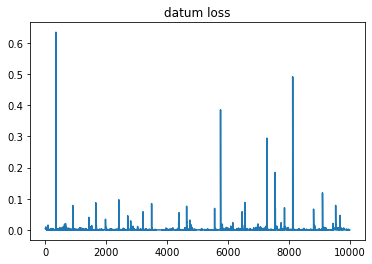

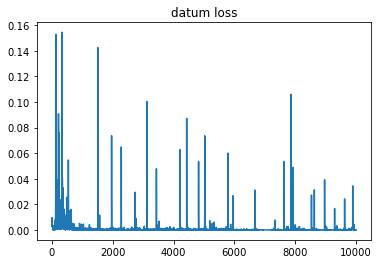

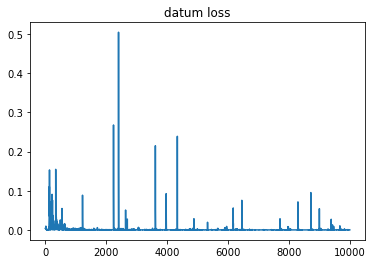

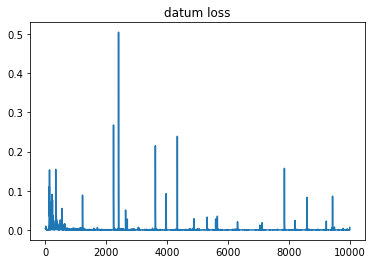

In [16]:
%matplotlib inline
for info in infos:
    plt.title('datum loss')
    plt.plot(info['datum_loss'])
    plt.show()

In [17]:
%matplotlib widget
plt.title('mass over time')
all_data = learners[-1].buffer.get_all()[-1]
plt.plot(all_data[:, 0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
%matplotlib widget
start = 1000
end = 2000
plt.title('datum loss and mass')
plt.plot(info['datum_loss'][start:end])
all_data = learners[-1].buffer.get_all()[-1]
plt.plot(all_data[:, 0][start:end] * 0.2)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
batch = deepcopy(learners[-1].buffer.trajectories[0])
for i in range(len(batch)):
    batch[i] = np.expand_dims(np.array(batch[i]), axis=0)


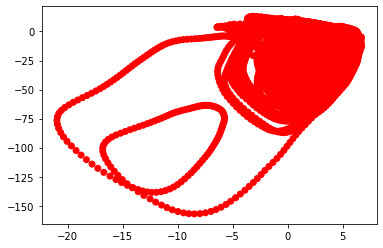

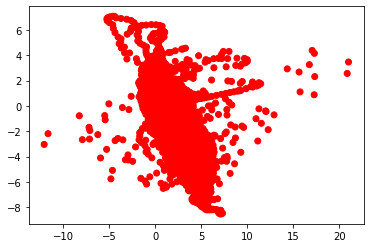

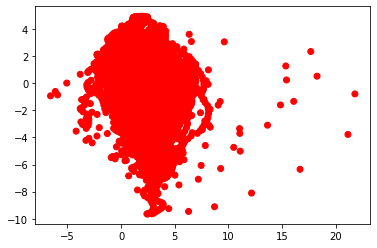

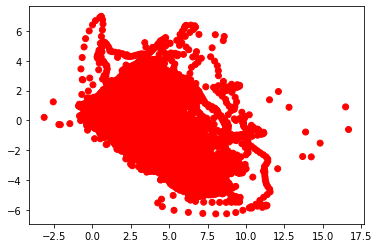

In [20]:
h = H
for learner in learners:
    x, y = learners[-1].buffer_to_osi_torch(batch)

    latents = []
    N = x.shape[1] - h
    for i in range(N):
        osi_in = x[:, i:i+h]
        osi_in = osi_in.clone().detach().to(device)
        latent = learner.osi_model(osi_in)
        latents.append(latent.cpu().detach().numpy())
    latents = np.concatenate(latents)
    masses = batch[-1][0][h:,0]
    colors = np.array(['r'] * N)
    colors[np.argwhere(masses == 1.0)] = 'g'
    colors[np.argwhere(masses == 1.5)] = 'b'
    colors[np.argwhere(masses == 0.5)] = 'y'
    
    %matplotlib inline
    plt.scatter(latents[:, 0], latents[:, 1], color=colors)
    plt.show()


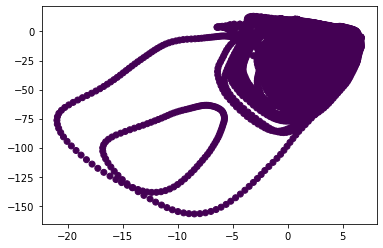

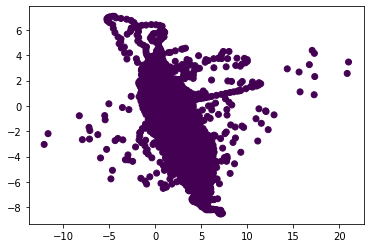

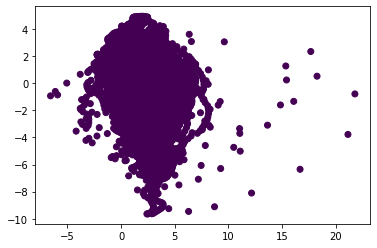

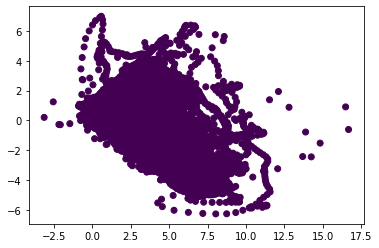

In [21]:
batch = deepcopy(learners[-1].buffer.trajectories[0])
for i in range(len(batch)):
    batch[i] = np.expand_dims(np.array(batch[i]), axis=0)

h = H
for learner in learners:
    x, y = learners[-1].buffer_to_osi_torch(batch)
    latents = []
    N = x.shape[1] - h
    mass = y[:, 0][h:]
    for i in range(N):
        osi_in = x[:, i:i+h]
        osi_in = osi_in.clone().detach().to(device)
        latent = learner.osi_model(osi_in)
        latents.append(latent.cpu().detach().numpy())
    latents = np.concatenate(latents)
    masses = batch[-1][0][h:,0]
    colors = np.array(masses) * 2.0 / 3.0 - 1.0 / 3.0
    %matplotlib inline
    plt.scatter(latents[:, 0], latents[:, 1], c=colors)
    plt.show()


## Regress the mass from the latents

In [22]:

def regress_params(learner, niters=1000):
    session = aim.Session(experiment='OSI_online_parameter_regression')
    model = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(device)

    batch_size = BATCH_SIZE
    lr = 5e-4
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    hp_dict = dict(niters=niters, lr=lr, batch_size=batch_size, h=h)
    session.set_params(hp_dict, name='hyperparameters')
    for i in range(niters):
        batch = learner.buffer.get_traj_batch(batch_size, h)
        x, y = learner.buffer_to_osi_torch(batch)

        x = x.to(device)
        y = y.to(device)
        
        optim.zero_grad()
        z = learner.osi_model(x)
        y_hat = model(z)
        loss = F.mse_loss(y_hat, y[:, 0].unsqueeze(-1))
        loss.backward()
        optim.step()
        session.track(loss.item(), name='loss')

        if i % 100 == 0:
            print(i, loss.item())

    session.close()
    return model

def osi_iid(learner, niters=1000):
    session = aim.Session(experiment='OSI_iid_parameter_regression')
    model = OSI

    batch_size = 64
    lr = 5e-4
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    hp_dict = dict(niters=niters, lr=lr, batch_size=batch_size, h=h)
    session.set_params(hp_dict, name='hyperparameters')
    for i in range(niters):
        batch = learner.buffer.get_traj_batch(batch_size, h)
        x, y = learner.buffer_to_osi_torch(batch)

        optim.zero_grad()
        z = learner.osi_model(x)
        y_hat = model(z)
        loss = F.mse_loss(y_hat, y[:, 0].unsqueeze(-1))
        loss.backward()
        optim.step()
        session.track(loss.item(), name='loss')

        if i % 100 == 0:
            print(i, loss.item())

    session.close()
    return model
    


In [23]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


if LOAD_LEARNERS:
    with open('data/param_model.pickle', 'rb') as f:
        param_model = pickle.load(f)
else:
    param_model = regress_params(learners[-1], niters=5000)
    with open('data/param_model.pickle', 'wb') as f:
        pickle.dump(param_model, f)

In [24]:
if LOAD_LEARNERS:
    with open('data/osi_model_iid.pickle', 'rb') as f:
        osi_model_iid = pickle.load(f)
else:
    osi_model_iid = train_osi_iid(env, learner.buffer, learner.buffer, h)
    with open('data/osi_model_iid.pickle', 'wb') as f:
        pickle.dump(osi_model_iid, f)

In [25]:
# Eval the online model
batch = learner.buffer.get_traj_batch(8, h)
x, y = learner.buffer_to_osi_torch(batch)
x = x.to(device)
z = learner.osi_model(x)
y_hat = param_model(z)
print('online model')
print(y_hat[:, 0])
print(y[:,0 ])

osi_model_iid = osi_model_iid.to(device)
y_hat = osi_model_iid(x)
print('iid')
print(y_hat[:, 0])
print(y[:,0 ])

print("mean y", torch.mean(y[:, 0]))

online model
tensor([1.6818, 1.6870, 1.6817, 1.6684, 1.6722, 1.6825, 1.6754, 1.6790],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755])
iid
tensor([1.6826, 1.6766, 1.6765, 1.6874, 1.6781, 1.6808, 1.6769, 1.6786],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755, 1.6755])
mean y tensor(1.6755)


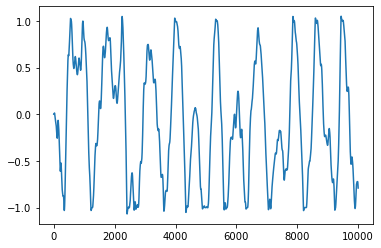

In [26]:
all_data = learner.buffer.get_all()
qpos = all_data[0]
qvel = all_data[1]
plt.plot(qpos[:, 0])
# plt.plot(qvel[:, 1])
plt.show()